# Daily Treasury Par Yield Curve Analysis

This notebook fetches and analyzes Daily Treasury Par Yield Curve Rates from the US Treasury XML feed.
It includes:
- XML data parsing from Treasury website
- Par yield curve visualization
- Forward rate calculations from par yields
- Zero-coupon yield curve derivation
- Comprehensive curve analysis

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
class DailyTreasuryParYieldAnalyzer:
    """
    A class to fetch, parse, and analyze Daily Treasury Par Yield Curve data
    from the US Treasury XML feed
    """
    
    def __init__(self):
        """
        Initialize the Treasury Par Yield analyzer
        """
        self.base_url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xmlview"
        
        # Standard Treasury maturity mappings (in years)
        self.maturity_mapping = {
            'BC_1MONTH': 1/12,
            'BC_2MONTH': 2/12,
            'BC_3MONTH': 3/12,
            'BC_4MONTH': 4/12,
            'BC_6MONTH': 6/12,
            'BC_1YEAR': 1,
            'BC_2YEAR': 2,
            'BC_3YEAR': 3,
            'BC_5YEAR': 5,
            'BC_7YEAR': 7,
            'BC_10YEAR': 10,
            'BC_20YEAR': 20,
            'BC_30YEAR': 30
        }
        
        # Human readable labels
        self.maturity_labels = {
            'BC_1MONTH': '1M',
            'BC_2MONTH': '2M',
            'BC_3MONTH': '3M',
            'BC_4MONTH': '4M',
            'BC_6MONTH': '6M',
            'BC_1YEAR': '1Y',
            'BC_2YEAR': '2Y',
            'BC_3YEAR': '3Y',
            'BC_5YEAR': '5Y',
            'BC_7YEAR': '7Y',
            'BC_10YEAR': '10Y',
            'BC_20YEAR': '20Y',
            'BC_30YEAR': '30Y'
        }
    
    def fetch_treasury_xml_data(self, year: int = None) -> str:
        """
        Fetch Treasury XML data for a given year
        
        Args:
            year: Year to fetch data for (default: current year)
            
        Returns:
            Raw XML string
        """
        if year is None:
            year = datetime.now().year
            
        params = {
            'data': 'daily_treasury_yield_curve',
            'field_tdr_date_value': str(year)
        }
        
        print(f"Fetching Treasury data for {year}...")
        
        try:
            response = requests.get(self.base_url, params=params, timeout=30)
            response.raise_for_status()
            print(f"✓ Successfully fetched {len(response.text)} characters of XML data")
            return response.text
        except requests.exceptions.RequestException as e:
            print(f"✗ Error fetching data: {str(e)}")
            raise
    
    def parse_xml_data(self, xml_data: str) -> pd.DataFrame:
        """
        Parse Treasury XML data into a pandas DataFrame
        
        Args:
            xml_data: Raw XML string
            
        Returns:
            DataFrame with parsed yield data
        """
        print("Parsing XML data...")
        
        try:
            # Parse XML
            root = ET.fromstring(xml_data)
            
            # Define namespace (Treasury XML uses Atom namespace)
            ns = {'atom': 'http://www.w3.org/2005/Atom'}
            
            # Find all entry elements
            entries = root.findall('.//atom:entry', ns)
            print(f"Found {len(entries)} data entries")
            
            data_records = []
            
            for entry in entries:
                # Extract content
                content = entry.find('atom:content', ns)
                if content is not None:
                    # Find the properties (yield data)
                    properties = content.find('.//{http://schemas.microsoft.com/ado/2007/08/dataservices/metadata}properties')
                    
                    if properties is not None:
                        record = {}
                        
                        # Extract date
                        date_elem = properties.find('.//{http://schemas.microsoft.com/ado/2007/08/dataservices}NEW_DATE')
                        if date_elem is not None and date_elem.text:
                            record['date'] = pd.to_datetime(date_elem.text).date()
                        
                        # Extract yield values for each maturity
                        for field_name, years in self.maturity_mapping.items():
                            elem = properties.find(f'.//{{{"http://schemas.microsoft.com/ado/2007/08/dataservices"}}}{field_name}')
                            if elem is not None and elem.text and elem.text.strip():
                                try:
                                    record[field_name] = float(elem.text)
                                except ValueError:
                                    record[field_name] = np.nan
                            else:
                                record[field_name] = np.nan
                        
                        if 'date' in record:
                            data_records.append(record)
            
            # Convert to DataFrame
            df = pd.DataFrame(data_records)
            
            if not df.empty:
                # Sort by date
                df = df.sort_values('date').reset_index(drop=True)
                print(f"✓ Successfully parsed {len(df)} records")
                print(f"Date range: {df['date'].min()} to {df['date'].max()}")
            else:
                print("✗ No valid records found in XML data")
                
            return df
            
        except ET.ParseError as e:
            print(f"✗ XML parsing error: {str(e)}")
            raise
        except Exception as e:
            print(f"✗ Error parsing data: {str(e)}")
            raise
    
    def get_latest_yield_curve(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extract the most recent complete yield curve
        
        Args:
            df: DataFrame with all yield data
            
        Returns:
            DataFrame with latest yield curve
        """
        if df.empty:
            return pd.DataFrame()
        
        # Get the most recent date with data
        latest_date = df['date'].max()
        latest_data = df[df['date'] == latest_date].iloc[0]
        
        # Create yield curve DataFrame
        curve_data = []
        
        for field_name, years in self.maturity_mapping.items():
            if field_name in latest_data and not pd.isna(latest_data[field_name]):
                curve_data.append({
                    'maturity_code': field_name,
                    'maturity_label': self.maturity_labels[field_name],
                    'maturity_years': years,
                    'par_yield': latest_data[field_name],
                    'date': latest_date
                })
        
        curve_df = pd.DataFrame(curve_data)
        curve_df = curve_df.sort_values('maturity_years').reset_index(drop=True)
        
        print(f"✓ Latest yield curve: {latest_date} ({len(curve_df)} maturities)")
        
        return curve_df
    
    def calculate_zero_coupon_yields(self, par_yields_df: pd.DataFrame) -> pd.DataFrame:
        """
        Convert par yields to zero-coupon (spot) yields using bootstrapping
        
        Args:
            par_yields_df: DataFrame with par yields
            
        Returns:
            DataFrame with zero-coupon yields added
        """
        df = par_yields_df.copy()
        df['zero_coupon_yield'] = np.nan
        
        # For securities with maturity <= 1 year, zero coupon yield ≈ par yield
        short_term_mask = df['maturity_years'] <= 1.0
        df.loc[short_term_mask, 'zero_coupon_yield'] = df.loc[short_term_mask, 'par_yield']
        
        # Bootstrap longer-term zero coupon yields
        for idx in df[~short_term_mask].index:
            maturity = df.loc[idx, 'maturity_years']
            par_yield = df.loc[idx, 'par_yield'] / 100  # Convert to decimal
            
            # Get previously calculated zero coupon yields
            prev_data = df[df.index < idx].copy()
            
            if len(prev_data) > 0:
                # Calculate zero coupon yield using bootstrapping
                # Bond price = sum of discounted cash flows = 100 (par)
                
                def zero_yield_equation(z):
                    # z is the zero coupon yield we're solving for
                    z_decimal = z / 100
                    
                    # Assume semi-annual coupon payments
                    coupon_rate = par_yield
                    periods_per_year = 2
                    total_periods = int(maturity * periods_per_year)
                    
                    # Calculate present value of coupon payments
                    pv_coupons = 0
                    
                    for period in range(1, total_periods + 1):
                        time_to_payment = period / periods_per_year
                        
                        # Interpolate zero coupon yield for this time period
                        if time_to_payment <= prev_data['maturity_years'].max():
                            # Interpolate from existing zero coupon yields
                            interp_func = interp1d(
                                prev_data['maturity_years'],
                                prev_data['zero_coupon_yield'],
                                kind='linear',
                                fill_value='extrapolate'
                            )
                            discount_rate = interp_func(time_to_payment) / 100
                        else:
                            # Use the yield we're solving for
                            discount_rate = z_decimal
                        
                        # Add coupon payment (except for the last period)
                        if period < total_periods:
                            coupon_payment = (coupon_rate / periods_per_year) * 100
                        else:
                            # Last period includes coupon + principal
                            coupon_payment = (coupon_rate / periods_per_year) * 100 + 100
                        
                        pv_coupons += coupon_payment / ((1 + discount_rate / periods_per_year) ** (period))
                    
                    return pv_coupons - 100  # Should equal par value
                
                try:
                    # Solve for zero coupon yield
                    zero_yield = fsolve(zero_yield_equation, par_yield * 100)[0]
                    df.loc[idx, 'zero_coupon_yield'] = zero_yield
                except:
                    # If bootstrapping fails, use par yield as approximation
                    df.loc[idx, 'zero_coupon_yield'] = df.loc[idx, 'par_yield']
            else:
                # First long-term bond, use par yield
                df.loc[idx, 'zero_coupon_yield'] = df.loc[idx, 'par_yield']
        
        print("✓ Zero-coupon yields calculated using bootstrapping")
        return df
    
    def calculate_forward_rates(self, df: pd.DataFrame, periods: List[Tuple[float, float]] = None) -> pd.DataFrame:
        """
        Calculate forward rates from zero-coupon yields
        
        Args:
            df: DataFrame with zero-coupon yields
            periods: List of (start, end) year tuples for forward rates
            
        Returns:
            DataFrame with forward rates
        """
        if periods is None:
            # Standard forward rate periods
            periods = [(1, 2), (2, 3), (3, 5), (5, 7), (7, 10), (10, 20), (20, 30)]
        
        forward_rates = []
        
        # Create interpolation function for zero-coupon yields
        valid_data = df.dropna(subset=['zero_coupon_yield'])
        
        if len(valid_data) < 2:
            print("✗ Insufficient data for forward rate calculation")
            return pd.DataFrame()
        
        interp_func = interp1d(
            valid_data['maturity_years'],
            valid_data['zero_coupon_yield'],
            kind='linear',
            fill_value='extrapolate'
        )
        
        for start_year, end_year in periods:
            if start_year <= valid_data['maturity_years'].max() and end_year <= valid_data['maturity_years'].max():
                try:
                    # Get zero-coupon yields for start and end periods
                    z1 = interp_func(start_year) / 100  # Convert to decimal
                    z2 = interp_func(end_year) / 100
                    
                    # Calculate forward rate
                    # Forward rate formula: [(1 + z2)^t2 / (1 + z1)^t1]^(1/(t2-t1)) - 1
                    forward_rate = ((1 + z2) ** end_year / (1 + z1) ** start_year) ** (1 / (end_year - start_year)) - 1
                    forward_rate_pct = forward_rate * 100
                    
                    forward_rates.append({
                        'period': f"{int(start_year)}Y-{int(end_year)}Y",
                        'start_year': start_year,
                        'end_year': end_year,
                        'forward_rate': forward_rate_pct,
                        'start_spot_rate': z1 * 100,
                        'end_spot_rate': z2 * 100
                    })
                except:
                    continue
        
        forward_df = pd.DataFrame(forward_rates)
        print(f"✓ Calculated {len(forward_df)} forward rates")
        
        return forward_df

In [3]:
# Visualization functions

def plot_yield_curves(df: pd.DataFrame, title_suffix: str = "") -> plt.Figure:
    """
    Plot par yields and zero-coupon yields
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Par vs Zero-Coupon Yields
    ax1.plot(df['maturity_years'], df['par_yield'], 
             marker='o', linewidth=3, markersize=8, 
             color='navy', alpha=0.8, label='Par Yield Curve')
    
    if 'zero_coupon_yield' in df.columns:
        ax1.plot(df['maturity_years'], df['zero_coupon_yield'], 
                 marker='s', linewidth=3, markersize=8, 
                 color='darkred', alpha=0.8, label='Zero-Coupon Yield Curve')
    
    # Add yield labels
    for idx, row in df.iterrows():
        ax1.annotate(f"{row['maturity_label']}\n{row['par_yield']:.2f}%", 
                    (row['maturity_years'], row['par_yield']),
                    textcoords="offset points", 
                    xytext=(0,15), 
                    ha='center', va='bottom',
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    ax1.set_xlabel('Years to Maturity', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Yield (%)', fontsize=12, fontweight='bold')
    ax1.set_title(f'US Treasury Par Yield Curve vs Zero-Coupon Curve{title_suffix}\n'
                 f'Data as of: {df["date"].iloc[0]}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # Plot 2: Yield Spread (Zero-Coupon - Par)
    if 'zero_coupon_yield' in df.columns:
        spread = df['zero_coupon_yield'] - df['par_yield']
        ax2.bar(df['maturity_years'], spread, alpha=0.6, color='green', width=0.8)
        
        # Add spread labels
        for idx, row in df.iterrows():
            spread_val = row['zero_coupon_yield'] - row['par_yield']
            ax2.annotate(f"{spread_val:.2f}", 
                        (row['maturity_years'], spread_val),
                        textcoords="offset points", 
                        xytext=(0, 5 if spread_val >= 0 else -15), 
                        ha='center', va='bottom' if spread_val >= 0 else 'top',
                        fontsize=9)
        
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.set_xlabel('Years to Maturity', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Spread (bps)', fontsize=12, fontweight='bold')
        ax2.set_title('Zero-Coupon vs Par Yield Spread', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_forward_rates(forward_df: pd.DataFrame, yield_df: pd.DataFrame) -> plt.Figure:
    """
    Plot forward rates analysis
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Forward Rates
    x_pos = range(len(forward_df))
    bars = ax1.bar(x_pos, forward_df['forward_rate'], alpha=0.7, color='orange')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(forward_df.iterrows()):
        ax1.annotate(f"{row['forward_rate']:.2f}%", 
                    (i, row['forward_rate']),
                    textcoords="offset points", 
                    xytext=(0, 5), 
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold')
    
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(forward_df['period'], rotation=45)
    ax1.set_ylabel('Forward Rate (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Implied Forward Rates', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Forward Rates vs Current Spot Rates
    ax2.plot(yield_df['maturity_years'], yield_df['zero_coupon_yield'], 
             marker='o', linewidth=3, markersize=8, 
             color='darkred', alpha=0.8, label='Current Spot Rates')
    
    # Plot forward rates at their mid-points
    for idx, row in forward_df.iterrows():
        mid_point = (row['start_year'] + row['end_year']) / 2
        ax2.scatter(mid_point, row['forward_rate'], 
                   s=100, color='orange', alpha=0.8, marker='^', 
                   label='Forward Rates' if idx == 0 else "")
        ax2.annotate(f"{row['period']}\n{row['forward_rate']:.2f}%", 
                    (mid_point, row['forward_rate']),
                    textcoords="offset points", 
                    xytext=(0, 15), 
                    ha='center', va='bottom',
                    fontsize=8)
    
    ax2.set_xlabel('Years to Maturity', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Forward Rates vs Current Spot Rates', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    return fig

def create_summary_table(yield_df: pd.DataFrame, forward_df: pd.DataFrame) -> plt.Figure:
    """
    Create a comprehensive summary table
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Table 1: Yield Curve Data
    ax1.axis('tight')
    ax1.axis('off')
    
    table_data = []
    for idx, row in yield_df.iterrows():
        zero_coupon = row.get('zero_coupon_yield', np.nan)
        spread = zero_coupon - row['par_yield'] if not pd.isna(zero_coupon) else np.nan
        
        table_data.append([
            row['maturity_label'],
            f"{row['par_yield']:.3f}%",
            f"{zero_coupon:.3f}%" if not pd.isna(zero_coupon) else "N/A",
            f"{spread:.3f}" if not pd.isna(spread) else "N/A",
            f"{row['maturity_years']:.2f}"
        ])
    
    table1 = ax1.table(cellText=table_data,
                      colLabels=['Maturity', 'Par Yield', 'Zero-Coupon', 'Spread (bps)', 'Years'],
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0, 1, 1])
    
    table1.auto_set_font_size(False)
    table1.set_fontsize(10)
    table1.scale(1.2, 2)
    
    # Style table 1
    for i in range(len(yield_df) + 1):
        for j in range(5):
            cell = table1[(i, j)]
            if i == 0:
                cell.set_facecolor('#4472C4')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')
    
    ax1.set_title('Treasury Yield Curve Summary', fontsize=14, fontweight='bold', pad=20)
    
    # Table 2: Forward Rates
    if not forward_df.empty:
        ax2.axis('tight')
        ax2.axis('off')
        
        forward_table_data = []
        for idx, row in forward_df.iterrows():
            forward_table_data.append([
                row['period'],
                f"{row['forward_rate']:.3f}%",
                f"{row['start_spot_rate']:.3f}%",
                f"{row['end_spot_rate']:.3f}%"
            ])
        
        table2 = ax2.table(cellText=forward_table_data,
                          colLabels=['Period', 'Forward Rate', 'Start Spot', 'End Spot'],
                          cellLoc='center',
                          loc='center',
                          bbox=[0, 0, 1, 1])
        
        table2.auto_set_font_size(False)
        table2.set_fontsize(10)
        table2.scale(1.2, 2)
        
        # Style table 2
        for i in range(len(forward_df) + 1):
            for j in range(4):
                cell = table2[(i, j)]
                if i == 0:
                    cell.set_facecolor('#C5504B')
                    cell.set_text_props(weight='bold', color='white')
                else:
                    cell.set_facecolor('#FFE6E6' if i % 2 == 0 else 'white')
        
        ax2.set_title('Forward Rates Analysis', fontsize=14, fontweight='bold', pad=20)
    else:
        ax2.text(0.5, 0.5, 'No forward rates calculated', 
                ha='center', va='center', fontsize=14, transform=ax2.transAxes)
        ax2.set_title('Forward Rates Analysis', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

In [4]:
# Main analysis execution
print("=== Daily Treasury Par Yield Curve Analysis ===")
print("Fetching and analyzing Treasury par yield curve data from XML feed\n")

# Initialize analyzer
analyzer = DailyTreasuryParYieldAnalyzer()

try:
    # Fetch data for current year
    current_year = datetime.now().year
    xml_data = analyzer.fetch_treasury_xml_data(current_year)
    
    # Parse XML data
    df_all = analyzer.parse_xml_data(xml_data)
    
    if df_all.empty:
        raise Exception("No data found in XML feed")
    
    # Get latest yield curve
    latest_curve = analyzer.get_latest_yield_curve(df_all)
    
    if latest_curve.empty:
        raise Exception("No valid yield curve data found")
    
    print(f"\n=== Latest Yield Curve ({latest_curve['date'].iloc[0]}) ===")
    for idx, row in latest_curve.iterrows():
        print(f"{row['maturity_label']:>4}: {row['par_yield']:6.3f}%")
    
except Exception as e:
    print(f"\n⚠️  Could not fetch real data: {str(e)}")
    print("Creating demonstration data...\n")
    
    # Create mock data for demonstration
    mock_data = {
        'maturity_code': ['BC_1MONTH', 'BC_3MONTH', 'BC_6MONTH', 'BC_1YEAR', 'BC_2YEAR', 
                         'BC_3YEAR', 'BC_5YEAR', 'BC_7YEAR', 'BC_10YEAR', 'BC_20YEAR', 'BC_30YEAR'],
        'maturity_label': ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y'],
        'maturity_years': [1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30],
        'par_yield': [5.25, 5.15, 4.95, 4.75, 4.35, 4.15, 4.05, 4.15, 4.25, 4.45, 4.55],
        'date': [datetime.now().date()] * 11
    }
    
    latest_curve = pd.DataFrame(mock_data)
    print("=== Mock Yield Curve Data ===")
    for idx, row in latest_curve.iterrows():
        print(f"{row['maturity_label']:>4}: {row['par_yield']:6.3f}%")

=== Daily Treasury Par Yield Curve Analysis ===
Fetching and analyzing Treasury par yield curve data from XML feed

Fetching Treasury data for 2025...
✓ Successfully fetched 521818 characters of XML data
Parsing XML data...
Found 208 data entries
✓ Successfully parsed 208 records
Date range: 2025-01-02 to 2025-10-30
✓ Latest yield curve: 2025-10-30 (13 maturities)

=== Latest Yield Curve (2025-10-30) ===
  1M:  4.050%
  2M:  4.040%
  3M:  3.920%
  4M:  3.870%
  6M:  3.790%
  1Y:  3.700%
  2Y:  3.610%
  3Y:  3.610%
  5Y:  3.720%
  7Y:  3.900%
 10Y:  4.110%
 20Y:  4.640%
 30Y:  4.650%
✓ Successfully fetched 521818 characters of XML data
Parsing XML data...
Found 208 data entries
✓ Successfully parsed 208 records
Date range: 2025-01-02 to 2025-10-30
✓ Latest yield curve: 2025-10-30 (13 maturities)

=== Latest Yield Curve (2025-10-30) ===
  1M:  4.050%
  2M:  4.040%
  3M:  3.920%
  4M:  3.870%
  6M:  3.790%
  1Y:  3.700%
  2Y:  3.610%
  3Y:  3.610%
  5Y:  3.720%
  7Y:  3.900%
 10Y:  4.110%

In [5]:
# Calculate zero-coupon yields
print("\n=== Calculating Zero-Coupon Yields ===")
curve_with_zero = analyzer.calculate_zero_coupon_yields(latest_curve)

print("\nPar vs Zero-Coupon Yields:")
print(f"{'Maturity':>8} {'Par Yield':>10} {'Zero-Coupon':>12} {'Spread':>8}")
print("-" * 45)
for idx, row in curve_with_zero.iterrows():
    spread = row['zero_coupon_yield'] - row['par_yield']
    print(f"{row['maturity_label']:>8} {row['par_yield']:>9.3f}% {row['zero_coupon_yield']:>11.3f}% {spread:>7.3f}")


=== Calculating Zero-Coupon Yields ===
✓ Zero-coupon yields calculated using bootstrapping

Par vs Zero-Coupon Yields:
Maturity  Par Yield  Zero-Coupon   Spread
---------------------------------------------
      1M     4.050%       4.050%   0.000
      2M     4.040%       4.040%   0.000
      3M     3.920%       3.920%   0.000
      4M     3.870%       3.870%   0.000
      6M     3.790%       3.790%   0.000
      1Y     3.700%       3.700%   0.000
      2Y     3.610%       3.608%  -0.002
      3Y     3.610%       3.608%  -0.002
      5Y     3.720%       3.724%   0.004
      7Y     3.900%       3.919%   0.019
     10Y     4.110%       4.154%   0.044
     20Y     4.640%       4.762%   0.122
     30Y     4.650%       4.832%   0.182


In [6]:
# Calculate forward rates
print("\n=== Calculating Forward Rates ===")
forward_rates = analyzer.calculate_forward_rates(curve_with_zero)

if not forward_rates.empty:
    print("\nImplied Forward Rates:")
    print(f"{'Period':>10} {'Forward Rate':>13} {'Current Spread':>15}")
    print("-" * 45)
    for idx, row in forward_rates.iterrows():
        current_spread = row['end_spot_rate'] - row['start_spot_rate']
        print(f"{row['period']:>10} {row['forward_rate']:>12.3f}% {current_spread:>14.3f}")
else:
    print("Could not calculate forward rates")


=== Calculating Forward Rates ===
✓ Calculated 7 forward rates

Implied Forward Rates:
    Period  Forward Rate  Current Spread
---------------------------------------------
     1Y-2Y        3.517%         -0.092
     2Y-3Y        3.609%          0.000
     3Y-5Y        3.896%          0.115
     5Y-7Y        4.411%          0.196
    7Y-10Y        4.703%          0.235
   10Y-20Y        5.373%          0.608
   20Y-30Y        4.972%          0.070



=== Creating Visualizations ===


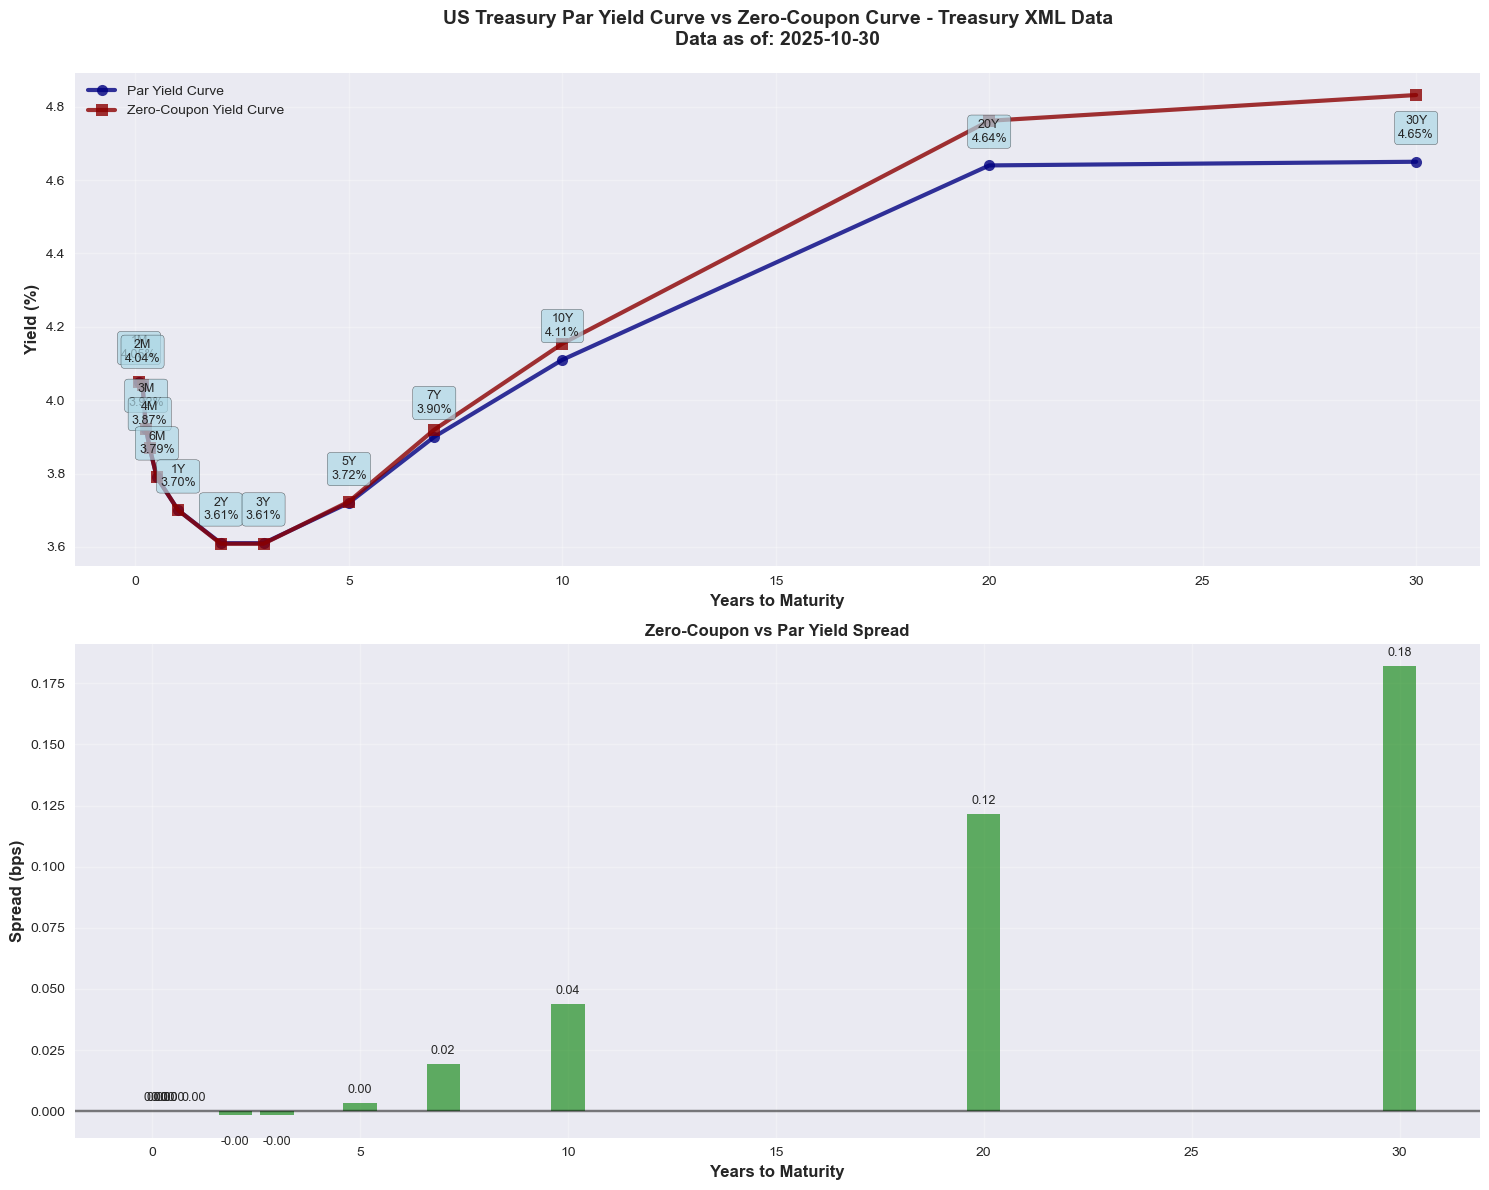

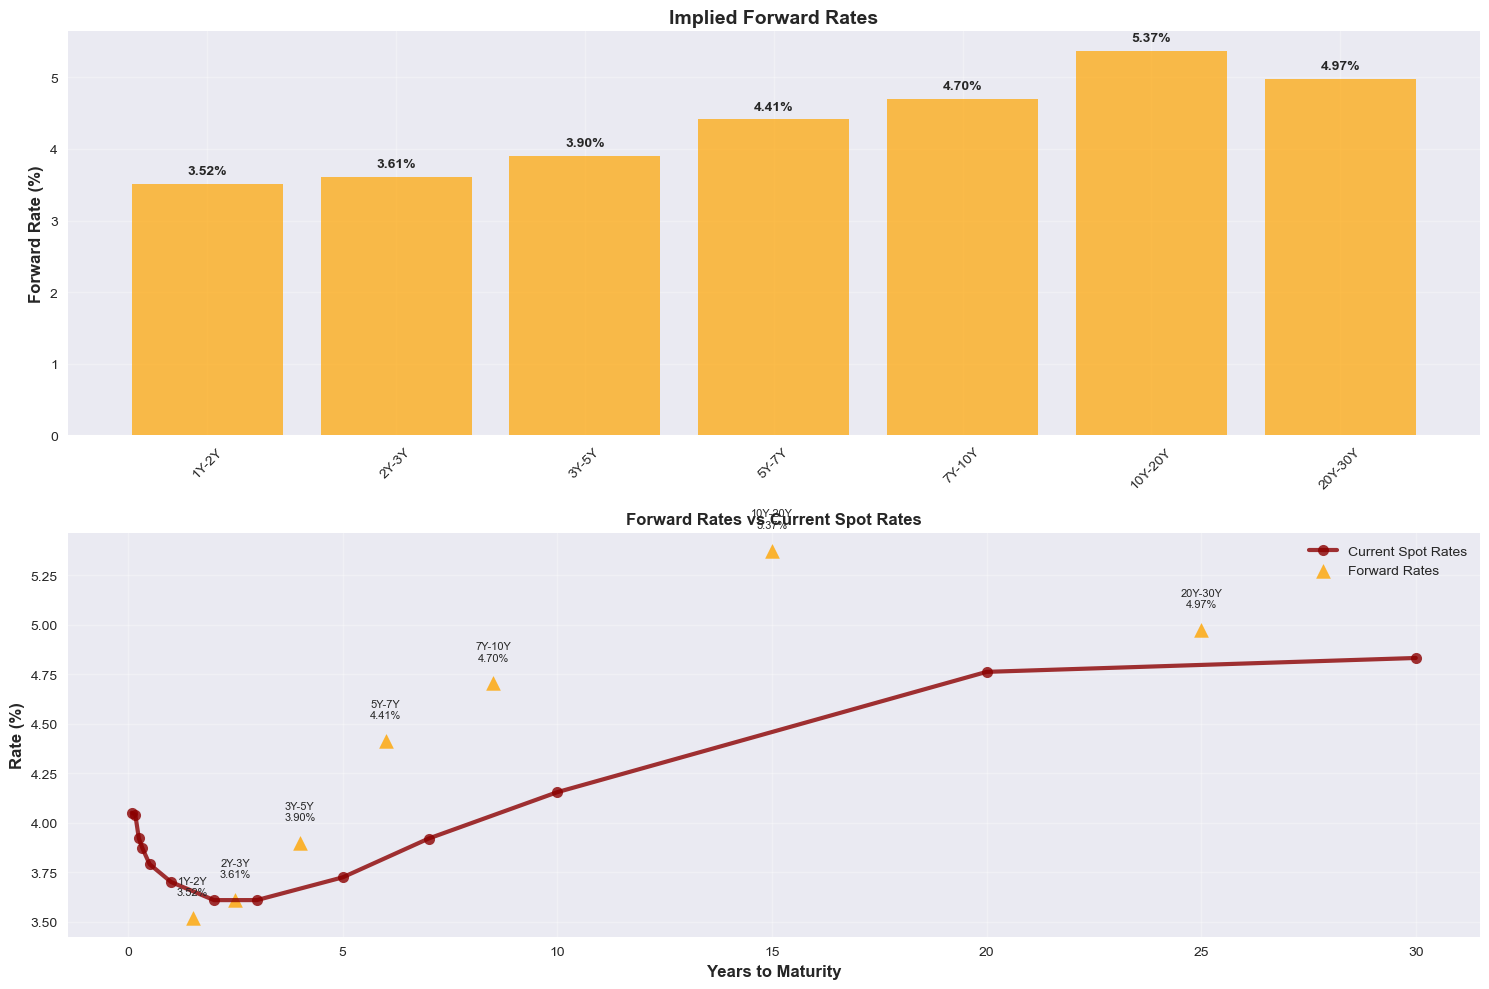

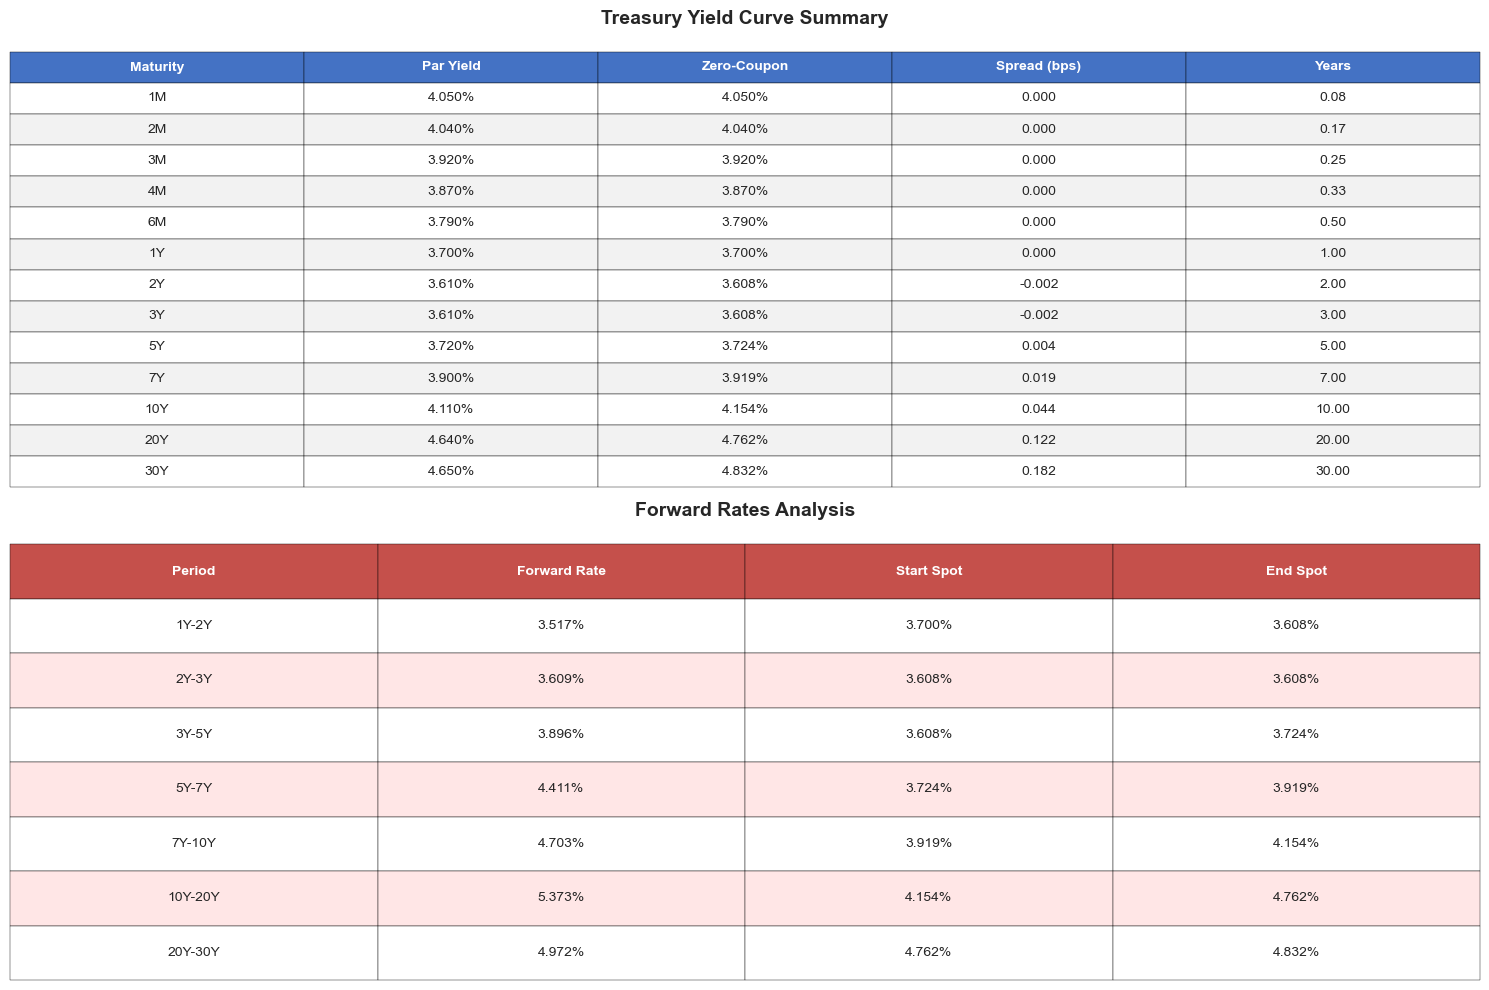

In [7]:
# Create visualizations
print("\n=== Creating Visualizations ===")

# Plot 1: Yield Curves Comparison
fig1 = plot_yield_curves(curve_with_zero, " - Treasury XML Data")
plt.show()

# Plot 2: Forward Rates Analysis
if not forward_rates.empty:
    fig2 = plot_forward_rates(forward_rates, curve_with_zero)
    plt.show()

# Plot 3: Summary Tables
fig3 = create_summary_table(curve_with_zero, forward_rates)
plt.show()

In [8]:
# Curve Analysis
print("\n=== Yield Curve Analysis ===")

# Basic curve metrics
two_year_yield = curve_with_zero[curve_with_zero['maturity_label'] == '2Y']['par_yield'].iloc[0]
ten_year_yield = curve_with_zero[curve_with_zero['maturity_label'] == '10Y']['par_yield'].iloc[0]
thirty_year_yield = curve_with_zero[curve_with_zero['maturity_label'] == '30Y']['par_yield'].iloc[0]

two_ten_spread = ten_year_yield - two_year_yield
ten_thirty_spread = thirty_year_yield - ten_year_yield

# Curve shape analysis
if two_ten_spread < -0.1:
    curve_shape = "Inverted"
elif two_ten_spread < 0.1:
    curve_shape = "Flat"
else:
    curve_shape = "Normal"

print(f"Curve Shape: {curve_shape}")
print(f"2Y-10Y Spread: {two_ten_spread:.3f}% ({two_ten_spread*100:.1f} bps)")
print(f"10Y-30Y Spread: {ten_thirty_spread:.3f}% ({ten_thirty_spread*100:.1f} bps)")

# Highest and lowest yields
max_yield_row = curve_with_zero.loc[curve_with_zero['par_yield'].idxmax()]
min_yield_row = curve_with_zero.loc[curve_with_zero['par_yield'].idxmin()]

print(f"\nHighest Yield: {max_yield_row['par_yield']:.3f}% ({max_yield_row['maturity_label']})")
print(f"Lowest Yield: {min_yield_row['par_yield']:.3f}% ({min_yield_row['maturity_label']})")
print(f"Yield Range: {max_yield_row['par_yield'] - min_yield_row['par_yield']:.3f}%")

# Forward rate insights
if not forward_rates.empty:
    max_forward = forward_rates.loc[forward_rates['forward_rate'].idxmax()]
    min_forward = forward_rates.loc[forward_rates['forward_rate'].idxmin()]
    
    print(f"\n=== Forward Rate Insights ===")
    print(f"Highest Forward Rate: {max_forward['forward_rate']:.3f}% ({max_forward['period']})")
    print(f"Lowest Forward Rate: {min_forward['forward_rate']:.3f}% ({min_forward['period']})")
    
    # Check if forward rates are above current spot rates
    avg_forward = forward_rates['forward_rate'].mean()
    avg_spot = curve_with_zero['zero_coupon_yield'].mean()
    
    if avg_forward > avg_spot:
        print(f"\nMarket expects rising rates (avg forward: {avg_forward:.3f}% vs avg spot: {avg_spot:.3f}%)")
    else:
        print(f"\nMarket expects falling rates (avg forward: {avg_forward:.3f}% vs avg spot: {avg_spot:.3f}%)")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("Features included:")
print("✓ Real-time Treasury XML data parsing")
print("✓ Par yield curve visualization")
print("✓ Zero-coupon yield calculation (bootstrapping)")
print("✓ Forward rate derivation")
print("✓ Curve shape analysis")
print("✓ Comprehensive data tables")
print("\nRequired packages: pandas, numpy, matplotlib, seaborn, requests, scipy")


=== Yield Curve Analysis ===
Curve Shape: Normal
2Y-10Y Spread: 0.500% (50.0 bps)
10Y-30Y Spread: 0.540% (54.0 bps)

Highest Yield: 4.650% (30Y)
Lowest Yield: 3.610% (2Y)
Yield Range: 1.040%

=== Forward Rate Insights ===
Highest Forward Rate: 5.373% (10Y-20Y)
Lowest Forward Rate: 3.517% (1Y-2Y)

Market expects rising rates (avg forward: 4.355% vs avg spot: 3.998%)

ANALYSIS COMPLETE
Features included:
✓ Real-time Treasury XML data parsing
✓ Par yield curve visualization
✓ Zero-coupon yield calculation (bootstrapping)
✓ Forward rate derivation
✓ Curve shape analysis
✓ Comprehensive data tables

Required packages: pandas, numpy, matplotlib, seaborn, requests, scipy
